In [1]:
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from file_reader import read_file
from math import sqrt
import random
import time 


In [2]:
class MultiClassLogisticRegression:
    """
    A class implementing Multi-Class Logistic Regression with gradient descend optimization 
    and trust region optimization methods.
    
    Data: 
        X             (np.ndarray)  :  Input features. N x F  N = #samples. F = #features 
        y             (np.ndarray)  :  Target labels.  N x C  N = #samples. C = #classes
        w             (np.ndarray)  :  Model weights.  C x F  C = #classes. F = #features
        y_true        (np.ndarray)  :  List one-hot encoded labels
        
        loss          (list)        :  List of losses  
        classes       (list)        :  List of unique class labels
        class_labels  (dict)        :  dict of class labels
        
    """

    def __init__(self, X: np.ndarray, y: np.ndarray, random_seed: int = 22):
        np.random.seed(random_seed)

        self.loss = []
        self.times = []
        self.classes = np.unique(y)
        self.class_labels = {c: i for i, c in enumerate(self.classes)}
        self.w = np.random.rand(len(self.classes), X.shape[1])
        self.y_true = self.one_hot_encoding(y)

    def one_hot_encoding(self, y: np.ndarray) -> np.ndarray:
        """
            Perform one-hot encoding of target labels
            
            :return: array (NxC)
            Example: [[1,0,0],[0,0,1],[0,1,0]]
        """
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]

    def predict(self, X: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
            Predict probabilities for each class 
            :return array (NxC)

            Example: [[0.2, 0.5, 0.3], [0.1, 0.2, 0.7], [0.4, 0.4, 0.2]]
        """
        return np.array([self.softmax(x, w) for x in X])

    def softmax(self, x: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
            Compute softmax function on a single entry 
            :return array (1xC)
        """
        z = np.dot(x, w.T)
        max_z = np.max(z)
        exp_z = np.exp(z - max_z)  # Subtract the maximum value for numerical stability

        return exp_z / np.sum(exp_z)

    def predict_classes(self, X: np.ndarray) -> list:
        """
            Predict classes based on input features
            :return list of predicted classes 
        """
        probs = self.predict(X, self.w)
        class_indices = np.argmax(probs, axis=1)

        return [self.classes[c] for c in class_indices]

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        return np.mean(self.predict_classes(X) == y)

    def cross_entropy_loss(self, probs: np.ndarray, w: np.ndarray, lam: float) -> np.ndarray:
        """
            Compute cross-entropy loss with l2 regularization.
        """

        epsilon = 1e-10
        n_samples = self.y_true.shape[0]
        l2 =  lam * np.linalg.norm(w) ** 2
        clipped_probs = np.clip(probs, epsilon, 1 - epsilon)
        return l2 + (-1 / n_samples * np.sum(self.y_true * np.log(clipped_probs)))

    def cross_entropy_loss_gradient(self, X: np.ndarray, probs: np.ndarray, w: np.ndarray, lam: float) -> np.ndarray:
        """
            :return array (C x F)
        """
        l2 = 2 * lam * np.linalg.norm(w)

        return np.dot((probs - self.y_true).T, X) / X.shape[0] + l2

    def cross_entropy_hessian(self, X: np.ndarray, lam: float) -> np.ndarray:
        """
            :return array (F x F)
        """
        n_samples, n_features = X.shape
        n_classes = self.w.shape[0]
        probs = self.predict(X, self.w)
        H = np.zeros((n_features, n_features))

        for n in range(n_samples):
            p_n = probs[n]
            x_n = X[n]
            xxT = np.outer(x_n, x_n.T)

            for i in range(n_classes):
                H += (p_n[i] - p_n[i] * p_n[i]) * xxT

        return H / n_samples + lam

    def armijo_line_search(self, X: np.ndarray, G: np.ndarray, direction: np.ndarray, current_loss: float, alpha: float,
                           rho: float, c: float, lam: float) -> float:

        """
            :return Step size found by armijo line search.
        """
        while alpha > 1e-8:
            new_w = self.w + alpha * direction
            new_probs = self.predict(X, new_w)
            new_loss = self.cross_entropy_loss(new_probs, new_w, lam)
            if new_loss <= current_loss + c * alpha * np.linalg.norm(np.dot(G.T, direction)):
                return alpha

            alpha *= rho

        return alpha

    def gradient_descend(self, X: np.ndarray, max_epoch: int, alpha: float, rho: float, c: float, lam: float) -> None:
        """
            Perform gradient descend optimization to update model weights
        """

        start = time.time()
        for _ in range(max_epoch):
   
            probs = self.predict(X, self.w)
            loss = self.cross_entropy_loss(probs, self.w, lam)
            end = time.time()
            self.times.append( (end - start) * 1000)
            self.loss.append(loss)
            
            G = self.cross_entropy_loss_gradient(X, probs, self.w, lam)
            d = -G
            lr = self.armijo_line_search(X, G, d, loss, alpha, rho, c, lam)
            self.w += lr * d
           
    def cauchy_point(self, G: np.ndarray, B: np.ndarray, trust_radius: float) -> list:
        """ 
            :return cauchy point to be used in trust region method
        """

        cauchy_point = np.zeros_like(G)
        n_classes = G.shape[0]
        for i in range(n_classes):
            gTBg = np.dot(np.dot(G[i].T, B), G[i])
            g_norm = np.linalg.norm(G[i])
            if gTBg <= 0:
                alpha = trust_radius / g_norm
            else:
                alpha = min(trust_radius / g_norm, g_norm ** 2 / gTBg)
            cauchy_point[i] = -alpha * G[i]

        return cauchy_point

    def m(self, f_x: float, G: np.ndarray, B: np.ndarray, s: np.ndarray) -> float:
        """ 
            :return model approximation function 
        """

        res = []
        n_classes = G.shape[0]
        for i in range(n_classes):
            res.append(f_x + np.dot(G[i].T, s[i]) + 0.5 * np.dot(np.dot(s[i].T, B), s[i]))

        return np.mean(res)

    def trust_region(self, X: np.ndarray, trust_radius: float, max_trust_radius: float, max_epoch: int, eta1: float,
                     eta2: float, gamma1: float, gamma2: float, lam: float) -> None:
        """
            Perform trust region optimization to update model weight
        """
        start = time.time()
        for _ in range(max_epoch):
           
            probs = self.predict(X, self.w)
            loss = self.cross_entropy_loss(probs, self.w, lam)
            end = time.time()
            self.times.append( (end - start) * 1000)
            self.loss.append(loss)
    
            G = self.cross_entropy_loss_gradient(X, probs, self.w, lam)
            H = self.cross_entropy_hessian(X, lam)

            pk = self.cauchy_point(G, H, trust_radius)

            new_weight = self.w + pk
            new_probs = self.predict(X, new_weight)
            new_loss = self.cross_entropy_loss(new_probs, new_weight, lam)

            act_red = loss - new_loss
            pred_red = loss - self.m(loss, G, H, pk)

            if pred_red == 0.0:
                rho = eta1 + 1
            else:
                rho = act_red / pred_red

            # Choose the weight for the next iteration.
            if rho >= eta1:
                self.w += pk

            if rho >= eta2:
                trust_radius = (trust_radius + max_trust_radius) / 2
            elif rho >= eta1 or rho < eta2:
                trust_radius = gamma2 * trust_radius
            elif rho < eta1:
                trust_radius = gamma1 * trust_radius
            
            
            

In [3]:
def plot(loss_1, loss_2, time_1, time_2 ):
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plotting loss over iterations
    axs[0].plot(np.arange(1, len(loss_1) + 1), loss_1, label='Gradient Descent')
    axs[0].plot(np.arange(1, len(loss_2) + 1), loss_2, label='Trust Region')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    
    axs[0].set_xscale('log')
    
    axs[1].plot(time_1, loss_1, label='Gradient Descent')
    axs[1].plot(time_2, loss_2, label='Trust Region')
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    
    axs[1].set_xscale('log')

    plt.tight_layout()
    plt.show()

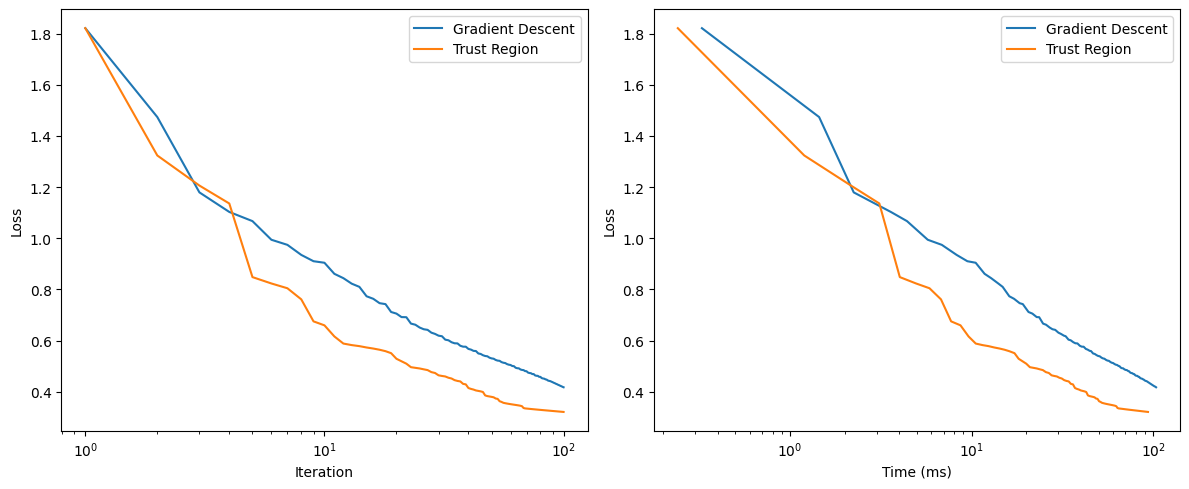

In [4]:
MAX_EPOCH = 100
ARMIJO_RHO = 0.5
ARMIJO_ALPHA = 0.4
ARMIJO_C = 1e-3
LAMBDA = 0.005

X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.1
ETA2 = 0.7
GAMMA1 = 0.2
GAMA2 = 0.8
lr1 = MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2 = MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH, ETA1, ETA2, GAMMA1, GAMA2, LAMBDA)
plot(lr1.loss, lr2.loss, lr1.times, lr2.times)



In [5]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter=1000)
sklearn_lg.fit(X_train, y_train)

print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test),  np.linalg.norm(lr1.w), np.linalg.norm(sklearn_lg.coef_) )
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test), np.linalg.norm(lr2.w) , np.linalg.norm(sklearn_lg.coef_) )


0.9428571428571428 0.9619047619047619 2.4231767181176624 3.295416623071267
0.9523809523809523 0.9619047619047619 3.5487522997504835 3.295416623071267


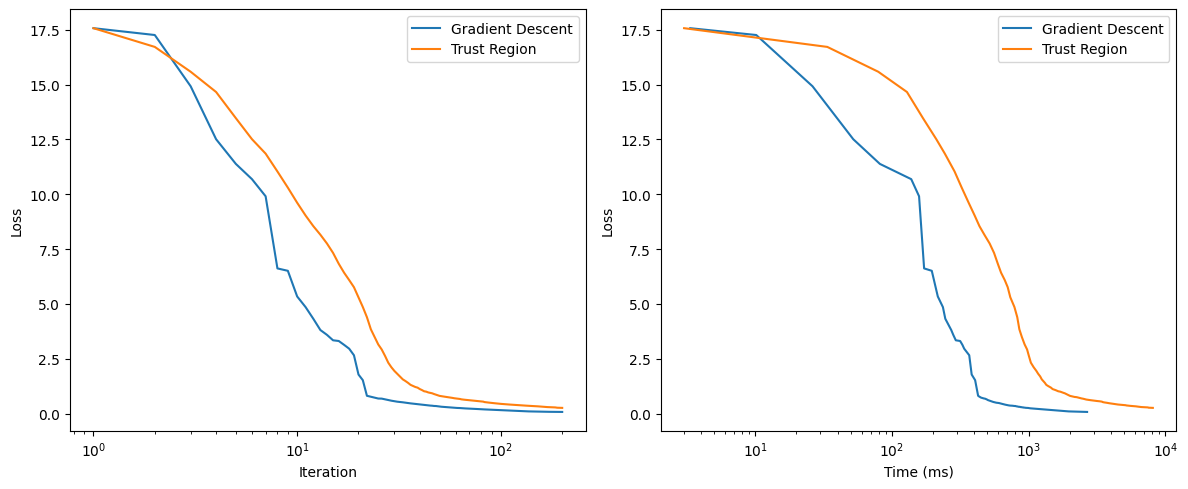

In [6]:
MAX_EPOCH = 200
ARMIJO_RHO = 0.5
ARMIJO_ALPHA = 0.2
ARMIJO_C = 1e-4
LAMBDA = 0.001

X, y = datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.1
ETA2 = 0.9
GAMMA1 = 0.2
GAMA2 = 0.8
lr1 = MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2 = MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH, ETA1, ETA2, GAMMA1, GAMA2, LAMBDA)

plot(lr1.loss, lr2.loss, lr1.times, lr2.times)

In [7]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter=10000)
sklearn_lg.fit(X_train, y_train)

print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test),  np.linalg.norm(lr1.w), np.linalg.norm(sklearn_lg.coef_) )
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test), np.linalg.norm(lr2.w) , np.linalg.norm(sklearn_lg.coef_) )


0.9157392686804452 0.9459459459459459 8.130258129175898 2.783515720245716
0.8744038155802861 0.9459459459459459 12.27358652240923 2.783515720245716


In [8]:
MAX_EPOCH = 100
ARMIJO_RHO = 0.5
ARMIJO_ALPHA = 0.5
ARMIJO_C = 1e-4
LAMBDA = 0.0005
X_train, y_train = read_file('datasets/dna/dna_train.txt', 180)
X_test, y_test = read_file('datasets/dna/dna_test.txt', 180)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.1
ETA2 = 0.3
GAMMA1 = 0.1
GAMA2 = 0.4
lr1 = MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2 = MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH, ETA1, ETA2, GAMMA1, GAMA2, LAMBDA)

In [9]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter=1000)
sklearn_lg.fit(X_train, y_train)

print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test),  np.linalg.norm(lr1.w), np.linalg.norm(sklearn_lg.coef_) )
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test), np.linalg.norm(lr2.w) , np.linalg.norm(sklearn_lg.coef_) )

0.9198988195615514 0.9418212478920742 7.14593322143536 10.504893020631645
0.918212478920742 0.9418212478920742 7.445510971063701 10.504893020631645


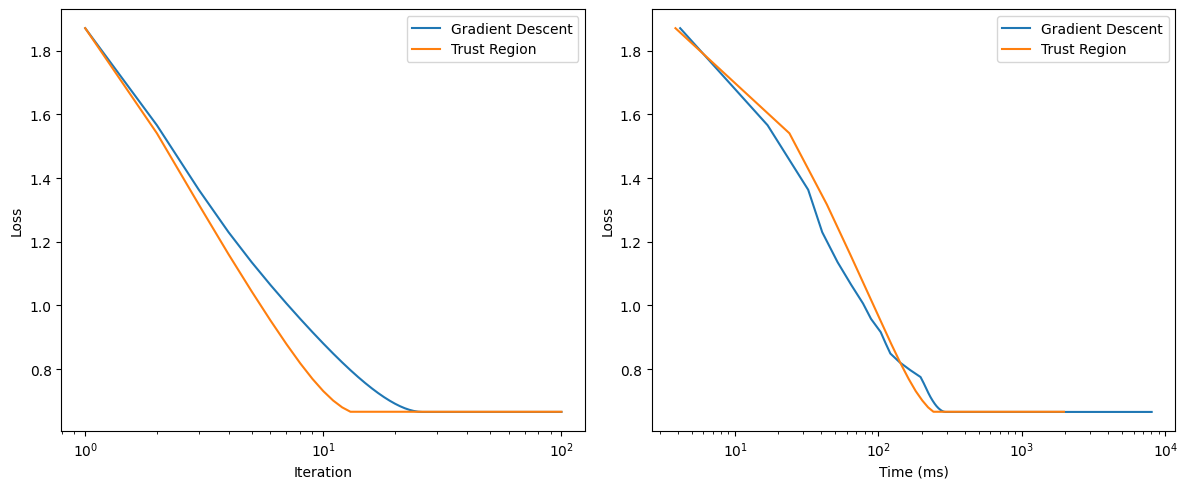

In [10]:
MAX_EPOCH = 100
ARMIJO_RHO = 0.5
ARMIJO_ALPHA = 0.4
ARMIJO_C = 1e-4
LAMBDA = 0.005

X_train, y_train = read_file('datasets/segment/segment_train.txt', 36)
X_test, y_test = read_file('datasets/segment/segment_test.txt', 36)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

INITIAL_TRUST_RADIUS = 1.0
MAX_TRUST_RADIUS = 100.0
ETA1 = 0.25
ETA2 = 0.75
GAMMA1 = 0.25
GAMA2 = 0.5
lr1 = MultiClassLogisticRegression(X_train, y_train)
lr1.gradient_descend(X_train, MAX_EPOCH, ARMIJO_ALPHA, ARMIJO_RHO, ARMIJO_C, LAMBDA)

lr2 = MultiClassLogisticRegression(X_train, y_train)
lr2.trust_region(X_train, INITIAL_TRUST_RADIUS, MAX_TRUST_RADIUS, MAX_EPOCH, ETA1, ETA2, GAMMA1, GAMA2, LAMBDA)

plot(lr1.loss, lr2.loss, lr1.times, lr2.times)

In [11]:
sklearn_lg = linear_model.LogisticRegression("l2", max_iter=500)
sklearn_lg.fit(X_train, y_train)

print(lr1.score(X_test, y_test), sklearn_lg.score(X_test, y_test),  np.linalg.norm(lr1.w), np.linalg.norm(sklearn_lg.coef_) )
print(lr2.score(X_test, y_test), sklearn_lg.score(X_test, y_test), np.linalg.norm(lr2.w) , np.linalg.norm(sklearn_lg.coef_) )

0.7331066723331917 0.7879303017424565 5.428708192962487 9.183612179587298
0.741606459838504 0.7879303017424565 5.189758059208227 9.183612179587298
